# Chapter 10: Observational Studies and Designed Experiments

## Part 1: Observational Studies

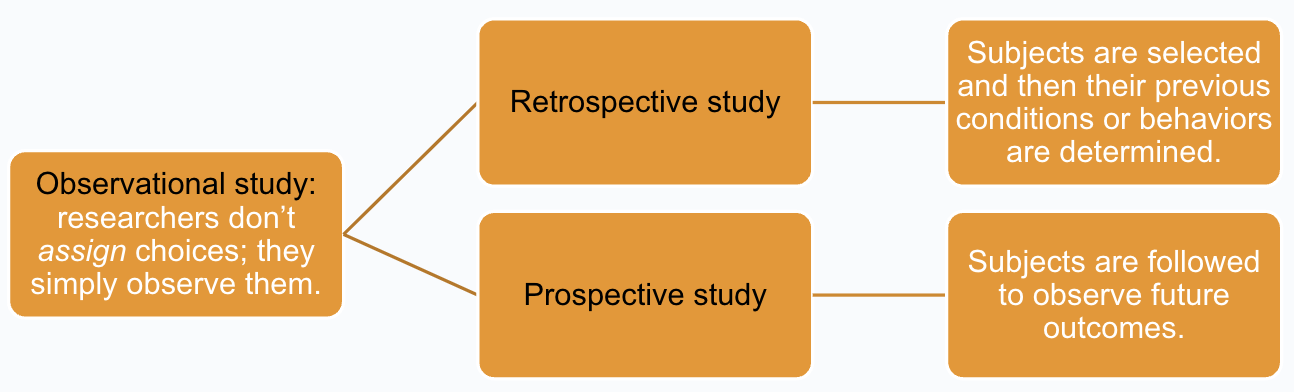

*   **Observational studies** are valuable for discovering trends and possible relationships.
*   However, whether prospective or retrospective, they **cannot demonstrate a cause-and-effect relationship**.


### Retrospective or Prospective?

**Retrospective**: Subjects are selected and their previous conditions or behaviors are determined.
**Prospective**: Subjects are followed to observe future outcomes.

**examples:**
1.  **Screen Time**: A university recruits 200 students and asks them to log their daily screen time and sleep duration for the next 6 months.
2.  **Study Habits**: A researcher investigates how study habits impact test scores. They track a group of students over the course of a school year, recording their study habits and test scores at regular intervals.
3.  **Smoking**: A group of researchers wanted to study the effects of smoking on lung health. They gathered medical records of 500 people who had already been diagnosed with lung cancer and examined their smoking histories to determine if there was a pattern.
4.  **Pesticides**: A team of scientists studies the potential connection between pesticide exposure and Parkinson’s disease. They identify a group of people who have been diagnosed with Parkinson’s and review their work histories to see if they were exposed to pesticides in the past.
5.  **Sugary Beverages**: Researchers are interested in the long-term health effects of drinking sugary beverages. They recruit 1,000 participants who currently do not have diabetes and track their beverage consumption and health outcomes over the next 10 years.
6.  **Neighborhood Cohesion**: A sociologist examines the effect of community events on neighborhood cohesion. They review past community event attendance records and survey long-time residents about their sense of neighborhood belonging.
7.  **Tree Planting**: An environmental scientist studies the impact of tree planting on reducing local temperatures. They identify neighborhoods planning large tree-planting initiatives and measure the area's temperature changes over the next decade.


## Lurking Variables

A **lurking variable** creates an association between two other variables that tempts us to think that one may cause the other.
*   This can happen in a regression analysis or an observational study.
*   A lurking variable is usually thought of as a **prior cause** of both *y* and *x* that makes it appear that *x* may be causing *y*.

### What could be the lurking variable?

1.  **Study 1**: Researchers find that neighborhoods with more **ice cream shops** have higher rates of **drowning incidents**.
2.  **Study 2**: Students who attend more **after-school tutoring sessions** tend to have **lower grades**.
3.  **Study 3**: Communities with more **libraries** have **higher literacy rates**.
4.  **Study 4**: Cities with more **coffee shops** have **higher crime rates**.
5.  **Study 5**: Communities where people own **convertible cars** receive **less rainfall**.


In [ ]:
# [DIGITAL LAB] Explore the Lurking Variable
# Run this cell to see how a hidden variable (Aggression) causes both Red Cars AND Accidents.

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

def explore_lurking_variables(aggressive_pct=0.3, red_preference=0.8):
    """
    Play with the sliders to see how the connection changes!
    """
    np.random.seed(42)
    n = 500
    aggression = np.random.choice([0, 1], size=n, p=[1-aggressive_pct, aggressive_pct])
    
    data = []
    for i in range(n):
        is_aggressive = aggression[i]
        if is_aggressive:
            car_color = np.random.choice(['Red', 'Black'], p=[red_preference, 1-red_preference])
            speed = np.random.normal(90, 10)
        else:
            car_color = np.random.choice(['White', 'Silver', 'Blue', 'Red'], p=[0.3, 0.3, 0.3, 0.1])
            speed = np.random.normal(60, 5)
        
        accident_risk = (speed - 50) / 100 
        has_accident = 1 if np.random.random() < accident_risk else 0
        data.append({'Color': car_color, 'Accident': has_accident})
        
    df_cars = pd.DataFrame(data)
    plt.figure(figsize=(8, 4))
    sns.barplot(data=df_cars, x='Color', y='Accident', errorbar=None, palette='viridis')
    plt.title(f"Accident Rate by Color (Aggressive Drivers: {aggressive_pct*100:.0f}%)")
    plt.ylabel("Probability of Accident")
    plt.show()

interact(explore_lurking_variables,
         aggressive_pct=FloatSlider(min=0.1, max=0.9, step=0.1, value=0.3, description='Aggression %'),
         red_preference=FloatSlider(min=0.5, max=1.0, step=0.1, value=0.8, description='Red Love %'))

## Part 2: Designed Experiments

An experiment allows us to prove cause and effect relationships.
The experimenter must identify at least one explanatory variable, called the **factor**, to manipulate at least one response variable to measure.

A **designed experiment**:
*   Manipulates factor levels to create treatments.
*   Randomly assigns subjects to these treatment levels.
*   Compares the responses of the subject groups across treatment levels.

### Vocabulary
*   **Experimental Units**: The individuals on whom we experiment. When humans are involved, they are called **Subjects** or **Participants**.
*   **Levels**: The specific values that the experimenter chooses for a factor.
*   **Treatment**: A combination of specific levels from all factors that an experimental unit receives.


### Four Principles of Experimental Design

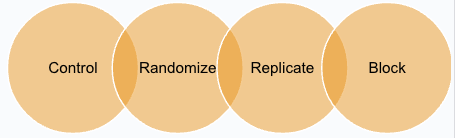

1.  **Control**: We control sources of variation (other than the factors) to make conditions similar for all groups.
2.  **Randomize**: Randomization allows us to equalize the effects of unknown or uncontrollable sources of variation. It spreads them out across treatment levels.
3.  **Replicate**: Repeat the experiment on many subjects. "An anecdote is not data."
4.  **Block**: Group similar individuals together (e.g., by age or soil type) and randomize *within* these blocks. This removes variability due to difference among blocks.


### Diagrams of Experiments

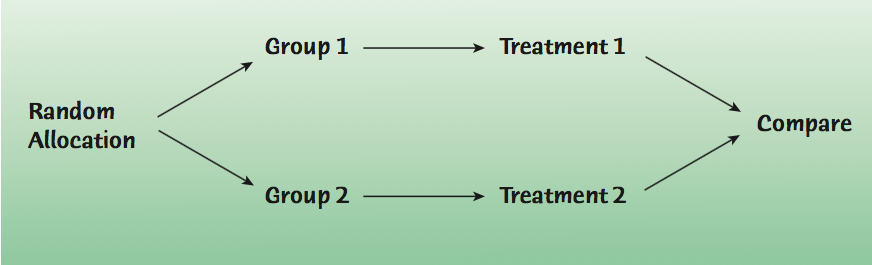

### Tree Diagrams for Blocking

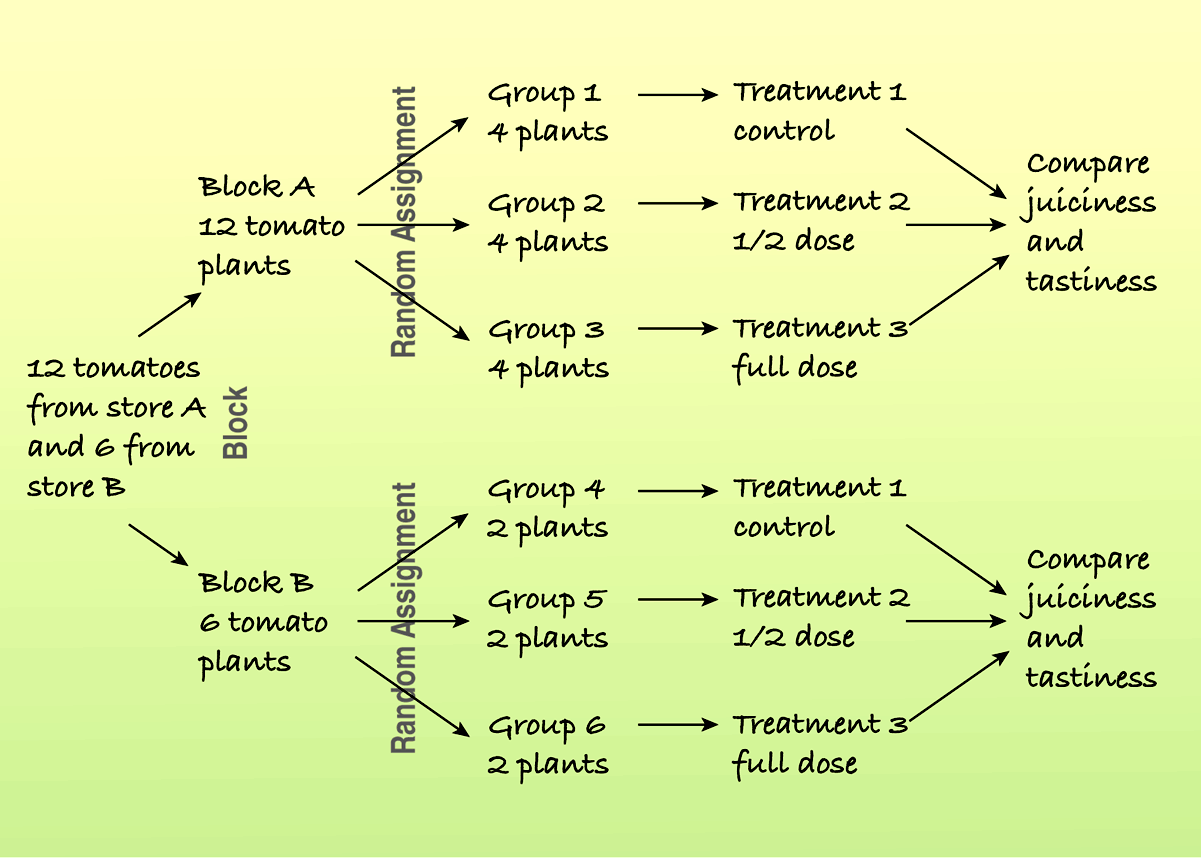

### Tree Diagrams with More Than One Factor

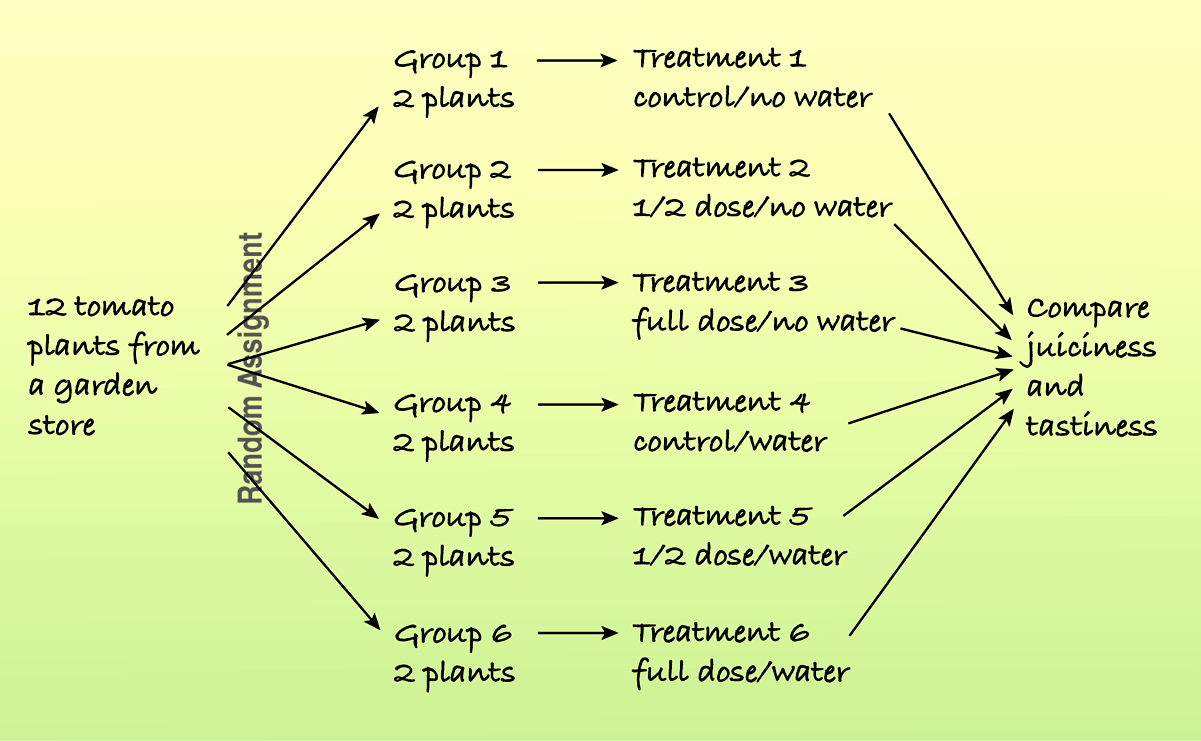


### Examples of Randomized Block Design

**1. Testing Fertilizers on Crop Yield**
*   **Experiment**: Test 3 fertilizers (A, B, C).
*   **Block**: Soil Type (Sandy, Loamy, Clayey).
*   **Randomization**: Within each soil block, randomly assign plots to fertilizers. This ensures soil type doesn't confound the results.

**2. Testing Pain Relief Therapies**
*   **Experiment**: Test 3 therapies (Medication, Acupuncture, Physical Therapy).
*   **Block**: Age Groups (20-30, 31-40, 41-50).
*   **Randomization**: Assign therapies randomly within each age group.

**3. Packaging Design Preference**
*   **Experiment**: Test 3 packages (Minimalist, Colorful, Eco-friendly).
*   **Block**: Demographics (Age, Gender, Income).
*   **Randomization**: Assign package types randomly within each demographic group.


### Blinding and Placebos

To avoid bias, we use **blinding**.
*   **Single-blind**: Subjects don't know which treatment they get.
*   **Double-blind**: Neither subjects nor evaluators know who got what.
*   **Placebo**: A "fake" treatment (like a sugar pill) used to blind subjects.

**Statistically Significant**: Differences larger than what we'd get from randomization alone.


In [ ]:
# [DIGITAL LAB] Simulate an Experiment
# Use this tool to see how 'Randomization' fixes Confounding.

import ipywidgets as widgets
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def run_simulation(use_randomization):
    conditions = ['Dry'] * 10 + ['Wet'] * 10
    
    if not use_randomization:
        treatments = ['System A'] * 10 + ['System B'] * 10 # Confounded!
        label = "POOR (Confounded)"
    else:
        treatments = np.random.choice(['System A', 'System B'], size=20)
        label = "GOOD (Randomized)"

    results = []
    for i in range(20):
        dist = 40
        if treatments[i] == 'System A': dist -= 5
        if conditions[i] == 'Wet': dist += 20
        dist += np.random.normal(0, 2)
        results.append({'Run': i, 'Condition': conditions[i], 'System': treatments[i], 'Distance': dist})
    
    df = pd.DataFrame(results)
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x='System', y='Distance', hue='Condition', palette='Set2')
    plt.title(f"Results: {label}")
    plt.show()

widgets.interact(run_simulation, use_randomization=widgets.Checkbox(value=False, description='Enable Randomization'));

## Confounding

When the levels of one factor are associated with the levels of another factor, we say they are **confounded**. We cannot separate their effects.

### What could be the confounding factor?

1.  **Experiment 1 (Fertilizer)**: Treated fields are closer to a **water source**.
2.  **Experiment 2 (Teaching)**: The new method is introduced to an **honors class**.
3.  **Experiment 3 (Fitness)**: Participants are assigned based on **gym attendance frequency**.
4.  **Experiment 4 (Diet)**: One group attends a **weekly support meeting**; the other does not.
5.  **Experiment 5 (WFH)**: Compares **volunteers** vs. those who stay in office.


### Final Challenge: Design Your Own Experiment

**Scenario**: Your school wants to know if a new study app actually helps students improve their grades.

**Your Task**: Design an experiment using the Four Principles. Fill in:
1.  **Research Question**: _________________________
2.  **Factor(s)**: _________________________
3.  **Levels**: _________________________
4.  **How will you CONTROL?** _________________________
5.  **How will you RANDOMIZE?** _________________________
6.  **How many REPLICATES?** _________________________
7.  **What variables should you BLOCK on?** _________________________
8.  **Possible CONFOUNDERS**: _________________________
